In [2]:
!pip install astral
!pip install skforecast
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.3/558.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.6 MB/s eta 0:00:00


In [3]:
# Data manipulation
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()


print(f"Versión skforecast: {skforecast.__version__}")
print(f"Versión lightgbm: {lightgbm.__version__}")
print(f"Versión scikit-learn: {sklearn.__version__}")

Versión skforecast: 0.12.0
Versión lightgbm: 4.1.0
Versión scikit-learn: 1.2.2


In [4]:
# Data download
data = fetch_dataset(name='vic_electricity', raw=True)
data.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [5]:
# Data preparation
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)

Demand  Temperature        Date  Holiday
Time                                                              
2011-12-31 13:00:00  4382.825174        21.40  2012-01-01     True
2011-12-31 13:30:00  4263.365526        21.05  2012-01-01     True

In [6]:
# Verify that a temporary index is complete
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [7]:
# Aggregating in 1H intervals
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data

Demand  Temperature  Holiday
Time                                                  
2011-12-31 14:00:00  4323.095350       21.225      1.0
2011-12-31 15:00:00  3963.264688       20.625      1.0
2011-12-31 16:00:00  3950.913495       20.325      1.0
2011-12-31 17:00:00  3627.860675       19.850      1.0
2011-12-31 18:00:00  3396.251676       19.025      1.0
...                          ...          ...      ...
2014-12-31 09:00:00  4069.625550       21.600      0.0
2014-12-31 10:00:00  3909.230704       20.300      0.0
2014-12-31 11:00:00  3900.600901       19.650      0.0
2014-12-31 12:00:00  3758.236494       18.100      0.0
2014-12-31 13:00:00  3785.650720       17.200      0.0

[26304 rows x 3 columns]

In [8]:
# Split data into train-val-test
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


In [9]:
%matplotlib notebook
%matplotlib inline

In [9]:
# Warnings configuration
import warnings
warnings.filterwarnings('once')

# Interactive plot of time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Demand",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

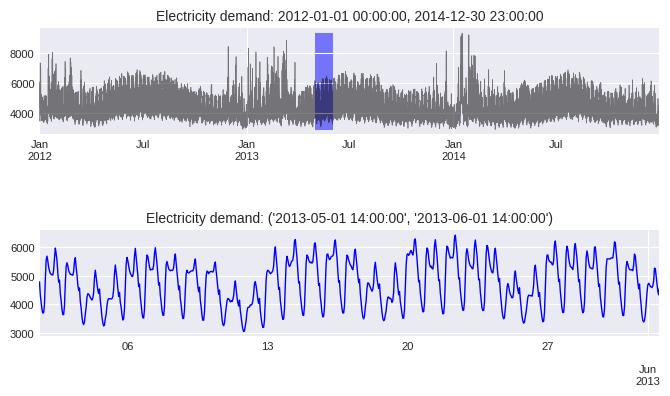

In [10]:
# Zooming time series chart

zoom = ('2013-05-01 14:00:00', '2013-06-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[:3, :])
data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Demand)
max_y = max(data.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')
zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)
plt.show();

In [11]:
# Create baseline: value of the same hour of the previous day
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Creation date: 2024-05-18 13:20:51 
Last fit date: 2024-05-18 13:20:51 
Skforecast version: 0.12.0 
Python version: 3.10.12 
Forecaster id: None 

In [12]:
# Backtesting
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error (MAE): 308.3752715958334


In [13]:
# Recursive
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )

# Train forecaster
forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs

In [14]:
# Backtesting
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Demand'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
# Backtesting error
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 236.38849515592196


In [17]:
# Hyperparameters search
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:end_validation, 'Demand'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.05513142057308684, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
  Backtesting metric: 237.8559671096808



In [18]:
# Search results
results_search.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags  \
4   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   

                                               params  mean_absolute_error  \
4   {'n_estimators': 800, 'max_depth': 8, 'learnin...           237.855967   
17  {'n_estimators': 900, 'max_depth': 9, 'learnin...           238.800194   
1   {'n_estimators': 1000, 'max_depth': 6, 'learni...           239.635156   
15  {'n_estimators': 900, 'max_depth': 10, 'learni...           239.716235   
14  {'n_estimators': 700, 'max_depth': 5, 'learnin...           244.464263   
10  {'n_estimators': 600, 'max_depth': 10, 'learni...           244.499025   
11  {'n_estimators': 1200, 'max_depth': 4, 'learni...           250.617539   
16  {'n_estimators': 1200, 'max_depth': 5, 'learni...           255.561203   
13  {'n_estimators': 900, 'max_depth': 7, 'learnin...           256.028143   
18  {'n_estimators': 700, 'max_depth': 9, 'learnin...           261.643103   

    n_estimators  max_depth  learning_rate  reg_alpha  reg_lambda  
4          800.0        8.0       0.055131        0.4         0.4  
17         900.0        9.0       0.077671        0.5         0.7  
1         1000.0        6.0       0.202138        0.3         0.8  
15         900.0       10.0       0.173305        0.4         0.8  
14         700.0        5.0       0.145675        0.0         0.3  
10         600.0       10.0       0.205234        0.4         0.0  
11        1200.0        4.0       0.218910        0.3         1.0  
16        1200.0        5.0       0.288489        0.3         0.3  
13         900.0        7.0       0.321041        0.3         0.8  
18         700.0        9.0       0.067970        0.8         0.6

In [19]:
# Best model
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.05513142057308684, max_depth=8, n_estimators=800,
              random_state=15926, reg_alpha=0.4, reg_lambda=0.4, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05513142057308684, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 800, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_

In [20]:
# Backtest final model on test data
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error: 198.26


pred
2014-12-01 00:00:00  5613.701110
2014-12-01 01:00:00  5597.650623
2014-12-01 02:00:00  5583.070192
2014-12-01 03:00:00  5607.766871
2014-12-01 04:00:00  5602.253078

In [10]:
# Exogneous Variables
# Calendar features
calendar_features = pd.DataFrame(index=data.index)
calendar_features['month'] = calendar_features.index.month
calendar_features['week_of_year'] = calendar_features.index.isocalendar().week
calendar_features['week_day'] = calendar_features.index.day_of_week + 1
calendar_features['hour_day'] = calendar_features.index.hour + 1

# Sunlight features
location = LocationInfo(
    "Melbourne",
    "Australia",
    latitude=-37.8,
    longitude=144.95,
    timezone='Australia/Melbourne'
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour},
                         index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features['is_daylight'] = np.where(
                                        (data.index.hour >= sun_light_features['sunrise_hour']) & \
                                        (data.index.hour < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )

# Holiday features
holiday_features = data[['Holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['Holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['Holiday'].shift(-24)

# Temperature features
temp_features = data[['Temperature']].copy()
temp_features['temp_roll_mean_1_day'] = temp_features['Temperature'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['Temperature'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['Temperature'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').min()


# Merge all exogenous variables
exogenous_features = pd.concat([
                         calendar_features,
                         sun_light_features,
                         temp_features,
                         holiday_features
                     ], axis=1)

exogenous_features.head(4)

month  week_of_year  week_day  hour_day  sunrise_hour  \
Time                                                                         
2012-01-01 00:00:00      1            52         7         1             6   
2012-01-01 01:00:00      1            52         7         2             6   
2012-01-01 02:00:00      1            52         7         3             6   
2012-01-01 03:00:00      1            52         7         4             6   

                     sunset_hour  daylight_hours  is_daylight  Temperature  \
Time                                                                         
2012-01-01 00:00:00           20              14            0       27.000   
2012-01-01 01:00:00           20              14            0       29.650   
2012-01-01 02:00:00           20              14            0       31.650   
2012-01-01 03:00:00           20              14            0       32.675   

                     temp_roll_mean_1_day  temp_roll_mean_7_day  \
Time                                                              
2012-01-01 00:00:00                   NaN                   NaN   
2012-01-01 01:00:00                   NaN                   NaN   
2012-01-01 02:00:00                   NaN                   NaN   
2012-01-01 03:00:00                   NaN                   NaN   

                     temp_roll_max_1_day  temp_roll_min_1_day  \
Time                                                            
2012-01-01 00:00:00                  NaN                  NaN   
2012-01-01 01:00:00                  NaN                  NaN   
2012-01-01 02:00:00                  NaN                  NaN   
2012-01-01 03:00:00                  NaN                  NaN   

                     temp_roll_max_7_day  temp_roll_min_7_day  Holiday  \
Time                                                                     
2012-01-01 00:00:00                  NaN                  NaN        1   
2012-01-01 01:00:00                  NaN                  NaN        1   
2012-01-01 02:00:00                  NaN                  NaN        1   
2012-01-01 03:00:00                  NaN                  NaN        1   

                     holiday_previous_day  holiday_next_day  
Time                                                         
2012-01-01 00:00:00                   NaN               1.0  
2012-01-01 01:00:00                   NaN               1.0  
2012-01-01 02:00:00                   NaN               1.0  
2012-01-01 03:00:00                   NaN               1.0

In [11]:
# Cliclical encoding of calendar and sunlight features
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(exogenous_features['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = cyclical_encoding(exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, cyclical_features], axis=1)
exogenous_features.head(3)

month  week_of_year  week_day  hour_day  sunrise_hour  \
Time                                                                         
2012-01-01 00:00:00      1            52         7         1             6   
2012-01-01 01:00:00      1            52         7         2             6   
2012-01-01 02:00:00      1            52         7         3             6   

                     sunset_hour  daylight_hours  is_daylight  Temperature  \
Time                                                                         
2012-01-01 00:00:00           20              14            0        27.00   
2012-01-01 01:00:00           20              14            0        29.65   
2012-01-01 02:00:00           20              14            0        31.65   

                     temp_roll_mean_1_day  ...  week_of_year_sin  \
Time                                       ...                     
2012-01-01 00:00:00                   NaN  ...               0.0   
2012-01-01 01:00:00                   NaN  ...               0.0   
2012-01-01 02:00:00                   NaN  ...               0.0   

                     week_of_year_cos  week_day_sin  week_day_cos  \
Time                                                                
2012-01-01 00:00:00               1.0 -2.449294e-16           1.0   
2012-01-01 01:00:00               1.0 -2.449294e-16           1.0   
2012-01-01 02:00:00               1.0 -2.449294e-16           1.0   

                     hour_day_sin  hour_day_cos  sunrise_hour_sin  \
Time                                                                
2012-01-01 00:00:00      0.258819      0.965926               1.0   
2012-01-01 01:00:00      0.500000      0.866025               1.0   
2012-01-01 02:00:00      0.707107      0.707107               1.0   

                     sunrise_hour_cos  sunset_hour_sin  sunset_hour_cos  
Time                                                                     
2012-01-01 00:00:00      6.123234e-17        -0.866025              0.5  
2012-01-01 01:00:00      6.123234e-17        -0.866025              0.5  
2012-01-01 02:00:00      6.123234e-17        -0.866025              0.5  

[3 rows x 30 columns]

In [12]:
# Interaction between exogenous variables
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'Temperature',
    'Holiday'
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
exogenous_features.head(4)

month  week_of_year  week_day  hour_day  sunrise_hour  \
Time                                                                         
2012-01-01 00:00:00      1            52         7         1             6   
2012-01-01 01:00:00      1            52         7         2             6   
2012-01-01 02:00:00      1            52         7         3             6   
2012-01-01 03:00:00      1            52         7         4             6   

                     sunset_hour  daylight_hours  is_daylight  Temperature  \
Time                                                                         
2012-01-01 00:00:00           20              14            0       27.000   
2012-01-01 01:00:00           20              14            0       29.650   
2012-01-01 02:00:00           20              14            0       31.650   
2012-01-01 03:00:00           20              14            0       32.675   

                     temp_roll_mean_1_day  ...  \
Time                                       ...   
2012-01-01 00:00:00                   NaN  ...   
2012-01-01 01:00:00                   NaN  ...   
2012-01-01 02:00:00                   NaN  ...   
2012-01-01 03:00:00                   NaN  ...   

                     poly_temp_roll_min_1_day__temp_roll_max_7_day  \
Time                                                                 
2012-01-01 00:00:00                                            NaN   
2012-01-01 01:00:00                                            NaN   
2012-01-01 02:00:00                                            NaN   
2012-01-01 03:00:00                                            NaN   

                     poly_temp_roll_min_1_day__temp_roll_min_7_day  \
Time                                                                 
2012-01-01 00:00:00                                            NaN   
2012-01-01 01:00:00                                            NaN   
2012-01-01 02:00:00                                            NaN   
2012-01-01 03:00:00                                            NaN   

                     poly_temp_roll_min_1_day__Temperature  \
Time                                                         
2012-01-01 00:00:00                                    NaN   
2012-01-01 01:00:00                                    NaN   
2012-01-01 02:00:00                                    NaN   
2012-01-01 03:00:00                                    NaN   

                     poly_temp_roll_min_1_day__Holiday  \
Time                                                     
2012-01-01 00:00:00                                NaN   
2012-01-01 01:00:00                                NaN   
2012-01-01 02:00:00                                NaN   
2012-01-01 03:00:00                                NaN   

                     poly_temp_roll_max_7_day__temp_roll_min_7_day  \
Time                                                                 
2012-01-01 00:00:00                                            NaN   
2012-01-01 01:00:00                                            NaN   
2012-01-01 02:00:00                                            NaN   
2012-01-01 03:00:00                                            NaN   

                     poly_temp_roll_max_7_day__Temperature  \
Time                                                         
2012-01-01 00:00:00                                    NaN   
2012-01-01 01:00:00                                    NaN   
2012-01-01 02:00:00                                    NaN   
2012-01-01 03:00:00                                    NaN   

                     poly_temp_roll_max_7_day__Holiday  \
Time                                                     
2012-01-01 00:00:00                                NaN   
2012-01-01 01:00:00                                NaN   
2012-01-01 02:00:00                                NaN   
2012-01-01 03:00:00                                NaN   

                     poly_temp_roll_min_7_day__Temperature  \
Time         

In [13]:
# Select exogenous variables to be included in the model
exog_features = []

# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())

# Columns that start with temp_ are selected
exog_features.extend(exogenous_features.filter(regex='^temp_.*').columns.tolist())

# Columns that start with holiday_ are selected
exog_features.extend(exogenous_features.filter(regex='^holiday_.*').columns.tolist())

# Include original features
exog_features.extend(['Temperature', 'Holiday'])

In [14]:
# Merge target and exogenous variables in the same DataFrame
data = data[['Demand']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='left'
       )

# Due to the creation of moving averages, there are missing values at the beginning of the series. Due to holiday_next_day there are missing values at the end.
data = data.dropna()
data = data.astype('float32')

# Split data into train-val-test
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

In [26]:
# Create forecaster
params = {
    'n_estimators': 800,
    'max_depth': 8,
    'learning_rate': 0.0551314,
    'reg_alpha': 0.4,
    'reg_lambda': 0.4,
    'random_state': 15926,
    'verbose': -1
}
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
# Backtesting model
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/29 [00:00<?, ?it/s]

Backtest error: 129.80


pred
2014-12-01 00:00:00  5561.629953
2014-12-01 01:00:00  5501.132966
2014-12-01 02:00:00  5453.086811
2014-12-01 03:00:00  5474.376494
2014-12-01 04:00:00  5530.322188

In [27]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_train, 'Demand'],
    exog = data.loc[:end_train, exog_features]
)
# Predict intervals
# Since the model has been trained with exogenous variables, they must be provided
# for the prediction.
predictions = forecaster.predict_interval(
                  exog     = data.loc[end_train:, exog_features],
                  steps    = 24,
                  interval = [10, 90],
              )
predictions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



pred  lower_bound  upper_bound
2014-01-01 00:00:00  3632.907595  3597.005697  3666.728409
2014-01-01 01:00:00  3779.814713  3730.780320  3813.333882
2014-01-01 02:00:00  3864.840701  3816.042311  3913.918539
2014-01-01 03:00:00  3931.732495  3854.539271  3985.687516
2014-01-01 04:00:00  3981.538258  3910.052319  4043.020729

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/334 [00:00<?, ?it/s]

negative    4620
positive    3396
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/skforecast/plot/plot.py:65: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



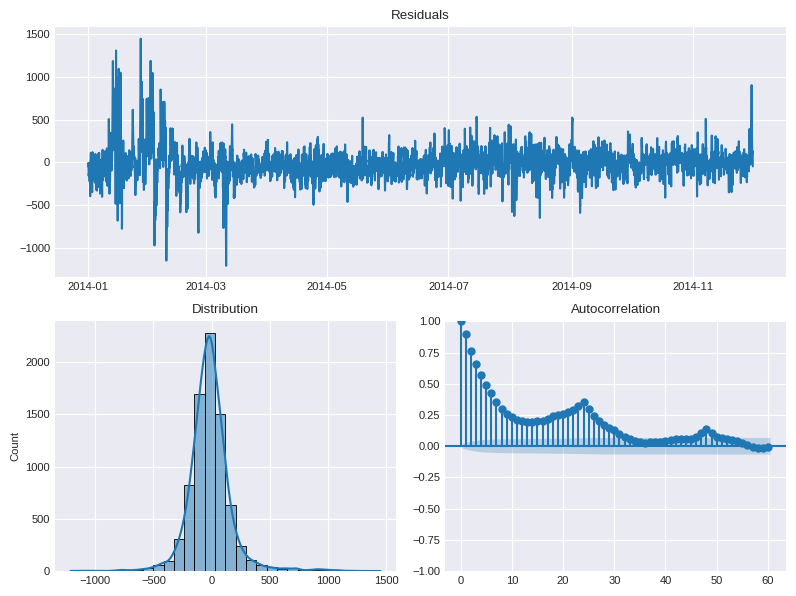

In [28]:
# Backtesting on validation data to obtain out-sample residuals
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'Demand'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
residuals = residuals.dropna()

# Out-sample residuals distribution
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
_ = plot_residuals(residuals=residuals, fig=fig)
fig.tight_layout()

# Store out-sample residuals in the forecaster
forecaster.set_out_sample_residuals(
    residuals = residuals,
    y_pred    = data.loc[predictions_val.index, 'Demand']
)

In [29]:
# Backtesting with prediction intervals in test data using out-sample residuals
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True, # Residuals conditioned on predicted values
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/29 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2014-12-01 00:00:00  5561.629953  5377.777405  5701.281989
2014-12-01 01:00:00  5501.132966  5190.982467  5788.547926
2014-12-01 02:00:00  5453.086811  5102.424659  5991.528615
2014-12-01 03:00:00  5474.376494  5037.869142  6262.746791
2014-12-01 04:00:00  5530.322188  5036.639154  6528.985275

In [30]:
# Plot prediction intervals vs real value
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=predictions.index,
        y=predictions['pred'],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=data_test.index,
        y=data_test['Demand'],
        mode='lines',
    ),
    go.Scatter(
        name='Upper Bound',
        x=predictions.index,
        y=predictions['upper_bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=predictions.index,
        y=predictions['lower_bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

In [31]:
# Predicted interval coverage (on test data)
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False
                  )
coverage = inside_interval.mean()
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Total area of the interval: 551718.67
Predicted interval coverage: 80.03 %


In [32]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'Demand'],
    exog = data.loc[:end_validation, exog_features]
)
# Model-specific feature importances
feature_importances = forecaster.get_feature_importances()
feature_importances.sort_values(by='importance', ascending=False).head(10)

feature  importance
0                              lag_1        2052
110                      Temperature        1046
23                            lag_24         912
1                              lag_2         882
87   poly_hour_day_sin__hour_day_cos         618
22                            lag_23         605
2                              lag_3         576
105              temp_roll_min_1_day         528
102             temp_roll_mean_1_day         461
104              temp_roll_max_1_day         449

In [33]:
# Training matrices used by the forecaster to fit the internal regressor
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train[exog_features]
                   )

display(X_train.head(3))
display(y_train.head(3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lag_1        lag_2        lag_3        lag_4  \
Time                                                                      
2012-01-09 00:00:00  4886.074219  4664.689453  4390.567871  3873.921631   
2012-01-09 01:00:00  4958.630371  4886.074219  4664.689453  4390.567871   
2012-01-09 02:00:00  5039.643066  4958.630371  4886.074219  4664.689453   

                           lag_5        lag_6        lag_7        lag_8  \
Time                                                                      
2012-01-09 00:00:00  3498.672607  3348.528809  3458.686523  3739.490967   
2012-01-09 01:00:00  3873.921631  3498.672607  3348.528809  3458.686523   
2012-01-09 02:00:00  4390.567871  3873.921631  3498.672607  3348.528809   

                           lag_9       lag_10  ...  temp_roll_mean_1_day  \
Time                                           ...                         
2012-01-09 00:00:00  3630.717285  3897.311035  ...             20.281250   
2012-01-09 01:00:00  3739.490967  3630.717285  ...             20.223959   
2012-01-09 02:00:00  3458.686523  3739.490967  ...             20.141666   

                     temp_roll_mean_7_day  temp_roll_max_1_day  \
Time                                                             
2012-01-09 00:00:00             22.389137            27.075001   
2012-01-09 01:00:00             22.308035            27.075001   
2012-01-09 02:00:00             22.224852            27.075001   

                     temp_roll_min_1_day  temp_roll_max_7_day  \
Time                                                            
2012-01-09 00:00:00                 14.8            39.525002   
2012-01-09 01:00:00                 14.8            39.525002   
2012-01-09 02:00:00                 14.8            39.525002   

                     temp_roll_min_7_day  holiday_previous_day  \
Time                                                             
2012-01-09 00:00:00                14.35                   0.0   
2012-01-09 01:00:00                14.35                   0.0   
2012-01-09 02:00:00                14.35                   0.0   

                     holiday_next_day  Temperature  Holiday  
Time                                                         
2012-01-09 00:00:00               0.0    19.200001      0.0  
2012-01-09 01:00:00               0.0    20.525000      0.0  
2012-01-09 02:00:00               0.0    21.100000      0.0  

[3 rows x 112 columns]

Time
2012-01-09 00:00:00    4958.630371
2012-01-09 01:00:00    5039.643066
2012-01-09 02:00:00    5090.203125
Freq: H, Name: y, dtype: float32

In [34]:
# Create SHAP explainer (for three base models)
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



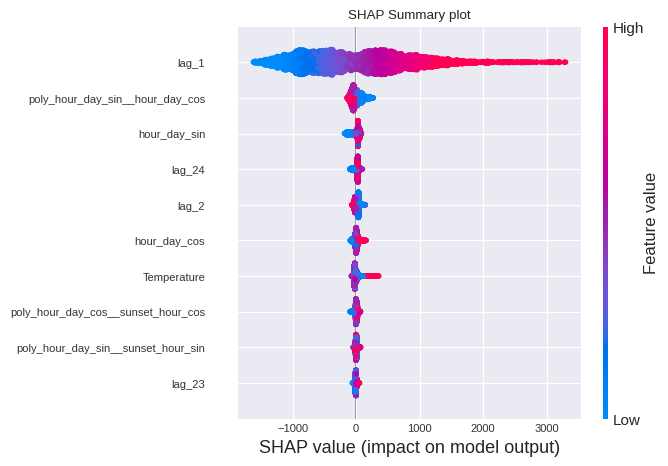

In [35]:
# Shap summary plot (top 10)
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [36]:
# # Force plot for the first observation
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [15]:
# Feature Selection
# Create forecaster
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 15926,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 24
             )

# Recursive feature elimination with cross-validation
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['Demand'],
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True
)

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 17352
Total number of records used for feature selection: 8676
Number of features available: 112
    Autoreg (n=24)
    Exog    (n=88)
Number of features selected: 67
    Autoreg (n=24) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    Exog    (n=43) : ['week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'hour_day_sin', 'hour_day_cos', 'poly_month_sin__week_of_year_sin', 'poly_month_sin__week_of_year_cos', 'poly_month_sin__week_day_cos', 'poly_month_sin__hour_day_sin', 'poly_month_sin__hour_day_cos', 'poly_month_cos__hour_day_sin', 'poly_month_cos__hour_day_cos', 'poly_week_of_year_sin__week_day_sin', 'poly_week_of_year_sin__hour_day_sin', 'poly_week_of_year_sin__hour_day_cos', 'poly_week_of_year_cos__week_day_sin', 'poly_week_of_year_cos__week_day_cos', 'poly_week_of_year_cos__hour_day_sin', 'poly_week_of_year_cos__hour_day_cos'

In [17]:
# Create forecaster
params = {
    'n_estimators': 800,
    'max_depth': 8,
    'learning_rate': 0.0551314,
    'reg_alpha': 0.4,
    'reg_lambda': 0.4,
    'random_state': 15926,
    'verbose': -1
}

In [18]:
# Create a forecaster with the selected features
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = selected_lags,
             )

# Backtesting model with exogenous variables on test data
metric_lgbm, predictions = backtesting_forecaster(
                               forecaster         = forecaster,
                               y                  = data['Demand'],
                               exog               = data[selected_exog],
                               steps              = 24,
                               metric             = 'mean_absolute_error',
                               initial_train_size = len(data[:end_validation]),
                               refit              = False,
                               n_jobs             = 'auto',
                               verbose            = False,
                               show_progress      = True
                           )
print(f"Backtest error: {metric_lgbm:.2f}")

  0%|          | 0/29 [00:00<?, ?it/s]

Backtest error: 129.00


In [19]:
# Forecaster with direct method
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(**params),
                 steps            = 24, # Steps to forecast
                 lags             = selected_lags
             )

# Backtesting model
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          exog               = data[selected_exog],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")
predictions.head()

  0%|          | 0/29 [00:00<?, ?it/s]

Backtest error (MAE): 120.66


pred
2014-12-01 00:00:00  5560.118920
2014-12-01 01:00:00  5643.764926
2014-12-01 02:00:00  5888.027943
2014-12-01 03:00:00  5930.036250
2014-12-01 04:00:00  6197.153056

In [20]:
# End of initial_train_size + 12 positions
data.iloc[:len(data.loc[:end_validation])+12].tail(2)

Demand     month_sin  month_cos  week_of_year_sin  \
Time                                                                          
2014-12-01 10:00:00  5084.011230 -2.449294e-16        1.0         -0.354605   
2014-12-01 11:00:00  4851.066895 -2.449294e-16        1.0         -0.354605   

                     week_of_year_cos  week_day_sin  week_day_cos  \
Time                                                                
2014-12-01 10:00:00          0.935016      0.781832       0.62349   
2014-12-01 11:00:00          0.935016      0.781832       0.62349   

                     hour_day_sin  hour_day_cos  sunrise_hour_sin  ...  \
Time                                                               ...   
2014-12-01 10:00:00  2.588190e-01     -0.965926          0.965926  ...   
2014-12-01 11:00:00  1.224647e-16     -1.000000          0.965926  ...   

                     temp_roll_mean_1_day  temp_roll_mean_7_day  \
Time                                                              
2014-12-01 10:00:00             25.589582             18.573214   
2014-12-01 11:00:00             25.129168             18.601191   

                     temp_roll_max_1_day  temp_roll_min_1_day  \
Time                                                            
2014-12-01 10:00:00            30.950001                 20.0   
2014-12-01 11:00:00            29.500000                 19.9   

                     temp_roll_max_7_day  temp_roll_min_7_day  \
Time                                                            
2014-12-01 10:00:00            33.849998                11.15   
2014-12-01 11:00:00            33.849998                11.15   

                     holiday_previous_day  holiday_next_day  Temperature  \
Time                                                                       
2014-12-01 10:00:00                   0.0               0.0        19.90   
2014-12-01 11:00:00                   0.0               0.0        19.35   

                     Holiday  
Time                          
2014-12-01 10:00:00      0.0  
2014-12-01 11:00:00      0.0  

[2 rows x 89 columns]

In [21]:
# Backtesting with gap
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = selected_lags,
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data[selected_exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12, # Number of positions to skip
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

print("")
print(f"Backtest error (MAE): {metric:.2f}")
predictions.head(5)

  0%|          | 0/28 [00:00<?, ?it/s]


Backtest error (MAE): 158.14


pred
2014-12-02 00:00:00  5457.045473
2014-12-02 01:00:00  5534.191363
2014-12-02 02:00:00  5665.586279
2014-12-02 03:00:00  5797.378587
2014-12-02 04:00:00  5958.440195